In [2]:
import os

In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configures matplotlib to inline and will display graphs below the corresponding cell
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

#for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

#manipulation of zipped images and getting numpy arrays of pixel values of images
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [4]:
X = []
Z = []
IMG_SIZE = 150
IMG_DIR = '../annotated-honeybee-dataset/bee_imgs/'

In [5]:
data = pd.read_csv('../annotated-honeybee-dataset/bee_data.csv')

In [6]:
health_counts = data["health"].value_counts()
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]

In [7]:
data = data[[status in target_categories for status in data["health"]]]
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
75,017_015.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
76,017_001.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
77,017_000.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
78,017_014.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [8]:
data["has_varroa"] = (data["health"] != "healthy").astype(int)
data["has_varroa"].head() # 0=healthy; 1=has_varroa

74    0
75    0
76    0
77    0
78    0
Name: has_varroa, dtype: int64

In [9]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

In [10]:
data = data[["file","has_varroa"]]
data.head()

,file,has_varroa
74,017_029.png,0
75,017_015.png,0
76,017_001.png,0
77,017_000.png,0
78,017_014.png,0


In [11]:
data.shape

(4435, 2)

In [12]:
type(data)

for index, row in data.iterrows():
    print(row['file'], row['has_varroa'])
    break

017_029.png 0


In [13]:
# def assign_label(img,bee_type):
#     return bee_type

In [14]:
def make_train_data(data, DIR):
    for index, row in data.iterrows():
        path = os.path.join(DIR, row['file'])
        label = str(row['has_varroa'])
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(np.array(img))
        Z.append(label)
        
#     for img in tqdm(os.listdir(DIR)):
#         label = assign_label(img, bee_type)
#         path = os.path.join(DIR, img)
#         ext = img[-4:]
#         if (ext != '.jpg'):
#             continue
#         img = cv2.imread(path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
#         X.append(np.array(img))
#         Z.append(str(label))

In [15]:
make_train_data(data, IMG_DIR)
print(len(X))

4435


In [16]:
# Gaussian Blur
# def blur():
#     for i in range(1, len(X)):
#         X[i] = cv2.GaussianBlur(X[i], (5, 5), 0) 

# Preprocessing
for i in range(len(X)):
    # Gaussian Blur
    im = X[i]
    im = cv2.GaussianBlur(im, (5, 5), 0)
    X[i] = im
    
# Not using the preprocessing below because they don't mark the bees very well
#     # Image Segmentation
#     gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     # Further noise removal
#     kernel = np.ones((3, 3), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
#     # sure background area
#     sure_bg = cv2.dilate(opening, kernel, iterations=3)
#     # Finding sure foreground area
#     dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#     ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
#     # Finding unknown region
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg, sure_fg)

#     # Marker labelling
#     ret, markers = cv2.connectedComponents(sure_fg)
#     # Add one to all labels so that sure background is not 0, but 1
#     markers = markers + 1
#     # Now, mark the region of unknown with zero
#     markers[unknown == 255] = 0
    
#     markers = cv2.watershed(im, markers)
#     im[markers == -1] = [255, 0, 0]
#     markers = cv2.watershed(X[i], markers)
#     X[i] = im

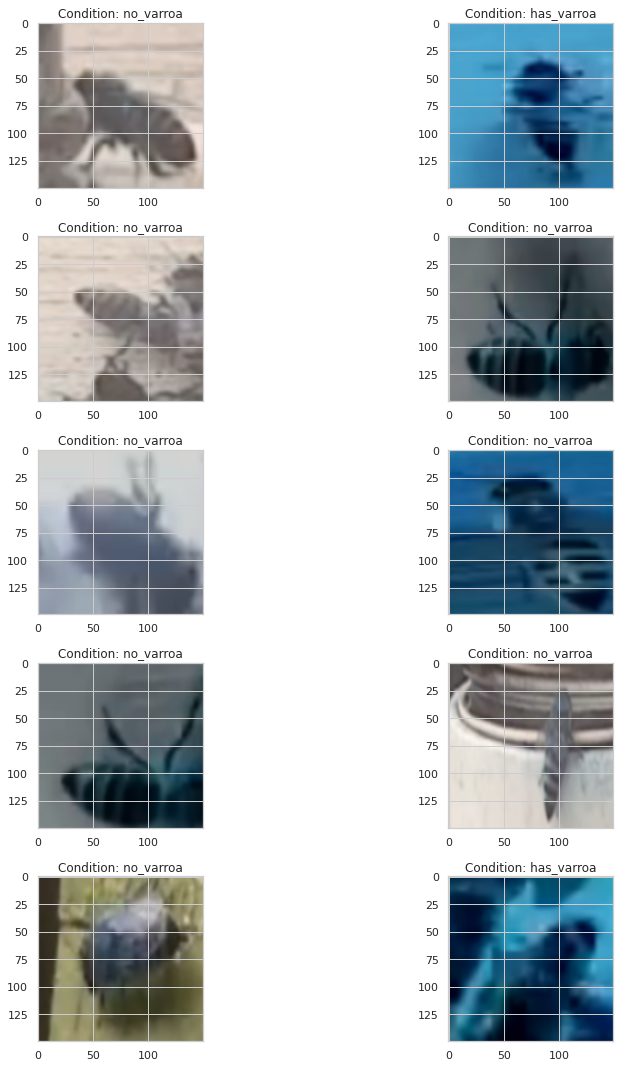

In [17]:
#visualize 10 random images with blurring preprocessing
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        label = 'has_varroa' if Z[l] == '1' else 'no_varroa'
        ax[i,j].set_title('Condition: '+ label)
plt.tight_layout()

In [18]:
# label encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [19]:
#splitting into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [20]:
#inputting the random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [21]:
# Using CNN to start modelling

# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
# #model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(2, activation = "softmax"))

params = {
    "conv__filters_1" : 32,
    "conv__filters_2" : 48,
    "conv__filters_3" : 64,
    "density_units_1" : 256,
    "density_units_2" : 64,
    "batch_size"      : 64,
    "epochs"          : 50
}

kernel_size = 3
dropout = .5
activation_func = "relu"
input_shape = (150,150,3)

conv__filters_1 = params.get('conv__filters_1') or 32
conv__filters_2 = params.get('conv__filters_2') or 16
conv__filters_3 = params.get('conv__filters_3') or 32
density_units_1 = params.get('density_units_1') or 32
density_units_2 = params.get('density_units_2') or 32
epochs          = params.get('epochs') or 8

model = Sequential([
        # Conv layer #1
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size + 4, 
            activation  = activation_func, 
            input_shape = input_shape, #input layer
            padding     = "same"
        ),
        Conv2D(filters = conv__filters_1, kernel_size = kernel_size + 4, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #2
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #3
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Dense layer #1
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        
        # Dense layer #2
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        
        # Output layer
        Dense(2, activation = "softmax")
    ])

In [22]:
# Using a LR Annealer

batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [23]:
# data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [26]:
x_test

array([[[[0.82745098, 0.83921569, 0.83921569],
         [0.82745098, 0.83921569, 0.83921569],
         [0.82745098, 0.83921569, 0.83921569],
         ...,
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784]],

        [[0.82352941, 0.83921569, 0.83921569],
         [0.82352941, 0.83921569, 0.83921569],
         [0.82352941, 0.83921569, 0.83921569],
         ...,
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784]],

        [[0.81960784, 0.83529412, 0.83529412],
         [0.81960784, 0.83529412, 0.83529412],
         [0.81960784, 0.83529412, 0.83529412],
         ...,
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784],
         [0.80784314, 0.81960784, 0.81960784]],

        ...,

        [[0.81176471, 0.82352941, 0.82352941],
         [0.81176471, 0.82352941, 0.82352941]

In [23]:
# compiling the model & summary
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      50208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 48)        57648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 48)        0

In [24]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [25]:
# fitting training set and making predictions on the validation set

History = model.fit(x_train, y_train, epochs=50)

# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test,y_test),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
104/104 [==============================] - 7s 66ms/step - loss: 0.5248 - accuracy: 0.7565
Epoch 2/50
104/104 [==============================] - 4s 39ms/step - loss: 0.3380 - accuracy: 0.7919
Epoch 3/50
104/104 [==============================] - 3s 33ms/step - loss: 0.4049 - accuracy: 0.7823
Epoch 4/50
104/104 [==============================] - 4s 42ms/step - loss: 0.4776 - accuracy: 0.7829
Epoch 5/50
104/104 [==============================] - 6s 56ms/step - loss: 0.3837 - accuracy: 0.8602
Epoch 6/50
104/104 [==============================] - 6s 54ms/step - loss: 0.2709 - accuracy: 0.9071
Epoch 7/50
104/104 [==============================] - 6s 57ms/step - loss: 0.2188 - accuracy: 0.9278
Epoch 8/50
104/104 [==============================] - 5s 44ms/step - loss: 0.2030 - accuracy: 0.9284
Epoch 9/50
104/104 [==============================] - 4s 43ms/step - loss: 0.1738 - accuracy: 0.9378
Epoch 10/50
104/104 [==============================] - 5s 51ms/step - loss: 0.1578 - accura

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print('\nTest accuracy:', test_acc)

35/35 [==============================] - 1s 30ms/step - loss: 0.1333 - accuracy: 0.9657

Test accuracy: 0.9657348990440369


In [27]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [29]:
predictions = probability_model.predict(x_test)

In [30]:
predictions[0]

array([0.7310585, 0.2689415], dtype=float32)

In [31]:
np.argmax(predictions[0])

0

In [33]:
class_names = ['No Varroa', 'With Varroa']

In [34]:
class_names[np.argmax(predictions[0])]

'No Varroa'

In [35]:
class_names[np.argmax(predictions[1])]

'No Varroa'

In [44]:
i = 0
for row in data.iterrows():
    print(i)
    i += 1
    print(row)
#     if row['has_varroa'] == 1:
#         print(row)
# data = data[["file","has_varroa"]]
# data

0
(74, file          017_029.png
has_varroa              0
Name: 74, dtype: object)
1
(75, file          017_015.png
has_varroa              0
Name: 75, dtype: object)
2
(76, file          017_001.png
has_varroa              0
Name: 76, dtype: object)
3
(77, file          017_000.png
has_varroa              0
Name: 77, dtype: object)
4
(78, file          017_014.png
has_varroa              0
Name: 78, dtype: object)
5
(79, file          017_028.png
has_varroa              0
Name: 79, dtype: object)
6
(80, file          017_002.png
has_varroa              0
Name: 80, dtype: object)
7
(81, file          017_016.png
has_varroa              0
Name: 81, dtype: object)
8
(82, file          017_017.png
has_varroa              0
Name: 82, dtype: object)
9
(83, file          017_003.png
has_varroa              0
Name: 83, dtype: object)
10
(84, file          017_007.png
has_varroa              0
Name: 84, dtype: object)
11
(85, file          017_012.png
has_varroa              0
Name: 85, dtype

In [46]:
class_names[np.argmax(predictions[1021])]

'With Varroa'

In [47]:
# graph for model accuracy between training and validation
# plt.plot(History.history['accuracy'])
# plt.plot(History.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['test', 'train'])
# plt.show()

In [48]:
# print(x_test)
# predictions = model.predict(x_test)
# print(predictions)
# print(predictions[0])

In [49]:
# class_names = ['No Varroa', 'With Varroa']

# def plot_image(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 class_names[true_label]),
#                                 color=color)

# def plot_value_array(i, predictions_array, true_label):
#   true_label = true_label[i]
#   plt.grid(False)
#   plt.xticks(range(7))
#   plt.yticks([])
#   thisplot = plt.bar(range(7), predictions_array, color="#777777")
#   plt.ylim([0, 1])
#   predicted_label = np.argmax(predictions_array)

#   thisplot[predicted_label].set_color('red')
#   thisplot[true_label].set_color('blue')

In [50]:
# y_ = [np.argmax(y_test, axis=None, out=None) for y in y_test]
# for i in range(100):
#     plt.figure(figsize=(6,3))
#     plt.subplot(1,2,1)
#     plot_image(i, predictions[i], y_, x_test)
#     plt.subplot(1,2,2)
#     plot_value_array(i, predictions[i], y_)
#     #plt.show()
# plt.tight_layout()

In [51]:
# export model
model_path = "../varroa_det_model_v1"
model.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../varroa_det_model_v1/assets


In [1]:
# load model
from tensorflow import keras
loaded_model = keras.models.load_model(model_path)

NameError: name 'model_path' is not defined

In [ ]:
# verify that the exported model works properly
prediction_by_model = model.predict(x)
prediction_by_loaded_model = loaded_model.predict(x_test)

In [ ]:
print(prediction_by_model[0])
print(prediction_by_loaded_model[0])

In [55]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def classify(img_path, saved_model, class_names):
    # Preprocess image
    IMG_SIZE = 150
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype("float") / 255.0
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    prediction = saved_model.predict(img_batch)
    # print(prediction)
    print(class_names[np.argmax(prediction)] + '(' + str(round(100*np.max(prediction), 2)) + '%)')

In [56]:
classify('../annotated-honeybee-dataset/bee_imgs/021_235.png', loaded_model, class_names)

No Varroa(99.59%)


In [57]:
classify('../annotated-honeybee-dataset/bee_imgs/038_042.png', loaded_model, class_names)

With Varroa(97.19%)


In [46]:
predictions = model.predict(x_test)
predictions

array([[1.0860465e-08, 1.0000000e+00],
       [3.0306299e-11, 1.0000000e+00],
       [4.0261776e-17, 1.0000000e+00],
       ...,
       [3.0029390e-09, 1.0000000e+00],
       [2.0609805e-02, 9.7939014e-01],
       [9.9775946e-01, 2.2404948e-03]], dtype=float32)

In [58]:
classify('../test_dataset/honeybee_with_varroa/001_001.jpeg', loaded_model, class_names)

No Varroa(100.0%)


In [60]:
classify('../test_dataset/honeybee_with_varroa/001_002.jpg', loaded_model, class_names)

No Varroa(100.0%)


In [61]:
classify('../test_dataset/honeybee_with_varroa/001_003.png', loaded_model, class_names)

No Varroa(100.0%)


In [62]:
classify('../test_dataset/honeybee_without_varroa/001_001.jpeg', loaded_model, class_names)

With Varroa(99.99%)


In [63]:
classify('../test_dataset/honeybee_without_varroa/001_002.jpg', loaded_model, class_names)

With Varroa(98.93%)


In [64]:
classify('../test_dataset/honeybee_without_varroa/001_003.jpeg', loaded_model, class_names)

No Varroa(88.57%)


In [66]:
classify('../bee_test/001_005.jpg', loaded_model, class_names)

No Varroa(100.0%)


In [67]:
classify('../bee_test/001_006.jpg', loaded_model, class_names)

No Varroa(100.0%)


In [69]:
classify('../bee_test/001_007.png', loaded_model, class_names)

No Varroa(100.0%)


In [70]:
classify('../bee_test/001_008.jpg', loaded_model, class_names)

No Varroa(100.0%)


In [71]:
classify('../bee_test/001_009.jpg', loaded_model, class_names)

No Varroa(100.0%)
